Title

# Introduction

Credit score is the prediction of your credit behavior, such as how likely you are to pay a loan back on time, based on information from your credit reports. Credit scores are used by financial institution to decide if they will lend you money. They also use credit score to determine how much interest they will charge you to borrow money. Credit scores are used to make a decision on whether to offer you a mortgage, credit card, auto loan, etc. In this analysis, we are trying to create an algorithm to predict a person’s credit score based on factors such as balance, and points earned. This analysis is important because it can be used to predict someone 

# Methods and Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(ggplot2)
library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

This Cell Loads the data set into Jupyter and cleans the column names into usable formats(ie. "Card Type" to "CardType") and changes the CardType Column from a character column to a factor column.

In [2]:
#Code Here
BankData <- read_csv("https://raw.githubusercontent.com/3deiuah/DSCI-100-Group-Project/main/Customer-Churn-Records.csv")
colnames(BankData)[16] <- "SatisfactionScore"
colnames(BankData)[17] <- "CardType"
colnames(BankData)[18] <- "PointEarned"
BankData <- mutate(BankData,CardType = as_factor(CardType)) 
head(BankData) #Data set loaded into R, Data Set is already Tidy

Rows: 10000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Surname, Geography, Gender, Card Type
dbl (14): RowNumber, CustomerId, CreditScore, Age, Tenure, Balance, NumOfPro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


RowNumber CustomerId Surname  CreditScore Geography Gender Age Tenure
1 1         15634602   Hargrave 619         France    Female 42  2     
2 2         15647311   Hill     608         Spain     Female 41  1     
3 3         15619304   Onio     502         France    Female 42  8     
4 4         15701354   Boni     699         France    Female 39  1     
5 5         15737888   Mitchell 850         Spain     Female 43  2     
6 6         15574012   Chu      645         Spain     Male   44  8     
  Balance   NumOfProducts HasCrCard IsActiveMember EstimatedSalary Exited
1      0.00 1             1         1              101348.88       1     
2  83807.86 1             0         1              112542.58       0     
3 159660.80 3             1         0              113931.57       1     
4      0.00 2             0         0               93826.63       0     
5 125510.82 1             1         1               79084.10       0     
6 113755.78 2             1         0              149756.71       1     
  Complain SatisfactionScore CardType PointEarned
1 1        2                 DIAMOND  464        
2 1        3                 DIAMOND  456        
3 1        3                 DIAMOND  377        
4 0        5                 GOLD     350        
5 0        5                 GOLD     425        
6 1        5                 DIAMOND  484

Table 1: Dataset used in Analysis

In [3]:
BankNA <- sum(is.na(BankData))
BankNA #No NA values in the data set.

[1] 0

We then check if there are any NA values present in the data set, which there are none.

In this specific analysis, we know that certain columns in this data set are not relevant, such as the CustomerId, RowNumber and Surname columns, so this cell removes them.(note: While we would have liked to leave the remaining data, we were running into memory issues, so a  sample is taken to limit the amount of data we have to process)

In [4]:
CleanBankData <- select(BankData, -CustomerId, -RowNumber, -Surname) |> select(Balance,PointEarned,CreditScore) |> rep_sample_n(4000) 
head(CleanBankData)

replicate Balance   PointEarned CreditScore
1 1              0.00 829         710        
2 1         119276.31 844         523        
3 1          83555.58 513         797        
4 1              0.00 818         850        
5 1         101707.80 425         617        
6 1          68432.45 384         640

Table 2: Selected Data for Analysis

Then to perform our Exploratory Data Analysis, we split the data into training and testing data.

In [5]:
bank_split <- initial_split(CleanBankData, prop = 0.5, strata = CreditScore)
bank_train <- training(bank_split)
bank_test <- testing(bank_split)

For our analysis, we wanted to use the Balance and Points earned for a customer to try to predict their credit score, so we calculated the mean and standard deviations for these columns.

In [6]:
Mean_sd_bank <- bank_train |> select(Balance, PointEarned,CreditScore) |> summarize(mean_Balance = mean(Balance),sd_Balance = sd(Balance),mean_Point = mean(PointEarned), 
                                         sd_Point = sd(PointEarned),
                                         mean_Credit = mean(CreditScore),sd_Credit = sd(CreditScore))
Mean_sd_bank

Adding missing grouping variables: `replicate`


replicate mean_Balance sd_Balance mean_Point sd_Point mean_Credit sd_Credit
1 1         75490.75     62426.39   605.731    225.7706 648.7045    97.23196

Table 3: Mean and Standard Deviation of Variables

While the means and standard deviations are not abnormal, the scales they range on are wildly different, so to do a k nearest neighbors analysis, we would have to standardize all of these values.

While we want to use Balance and Points earned to predict Credit Score, we can visualize the relationship between these two variables to see if there is any confounding between the two variables.

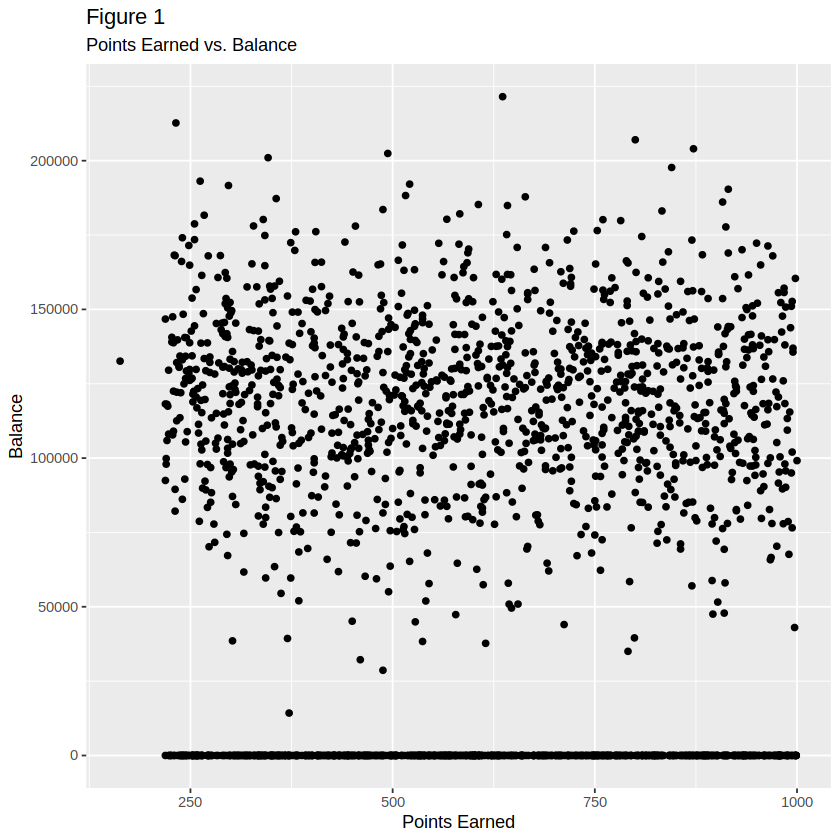

In [7]:
correlation_plot <- bank_train |> ggplot(aes(x = PointEarned,y=Balance)) + geom_point() + ylab("Balance") + xlab("Points Earned") + ggtitle("Figure 1",subtitle = "Points Earned vs. Balance")
correlation_plot

As we can see, there is not a significant relationship between the two variables, so we can rule out any confounding.

Then we can begin the data analysis, first creating a specification for a nearest neighbor regression model. We are tuning our k value in order to ensure a proper fit.

In [8]:
bank_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression")

We can then create a recipe to specify what our model will consider to predict Credit Score. As we are using knn regression and with the results found from the means and standard deviations(figure 3), we will also scale all of our predictors.

In [9]:
bank_recipe <- recipe(CreditScore ~ Balance+PointEarned, data = bank_train)
bank_knn_recipe <- bank_recipe |> step_scale(all_predictors()) |>
       step_center(all_predictors())

Then we can combine the specification and recipe in a workflow, then fitting the training data in as well.

In [10]:
bank_knn_fit <- workflow() |> add_recipe(bank_knn_recipe) |> add_model(bank_knn_spec) |> fit(data = bank_train)

Warning message:
“tune samples were requested but there were 2000 rows in the data. 1995 will be used.”


We can then tune our model. In this case, we are tuning from 1 to 20 by 2. Finding the lowest mean root mean squared deviation(rmse), we find the following result.

In [11]:
gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
bank_vfold <- vfold_cv(bank_train,v=5,strata = CreditScore)
bank_results <- bank_knn_fit |> tune_grid(resamples = bank_vfold,grid = gridvals) |> collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
bank_results

neighbors .metric .estimator mean     n std_err  .config              
1 10        rmse    standard   101.4104 5 1.983775 Preprocessor1_Model10

Table 4: Lowest Mean Root Mean Squared Deviation Result

As we can see, the best k value for this data set is 10, which is created and run in the following cell

In [12]:
bank_knn_spec_10 <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |> 
       set_engine("kknn") |>
       set_mode("regression")
bank_knn_fit_10 <- workflow() |> add_recipe(bank_knn_recipe) |> add_model(bank_knn_spec_10) |> fit(data = bank_train)

Next, we can plot our predicted credit score over the graphs for balance and Points earned to see how accurate they are.

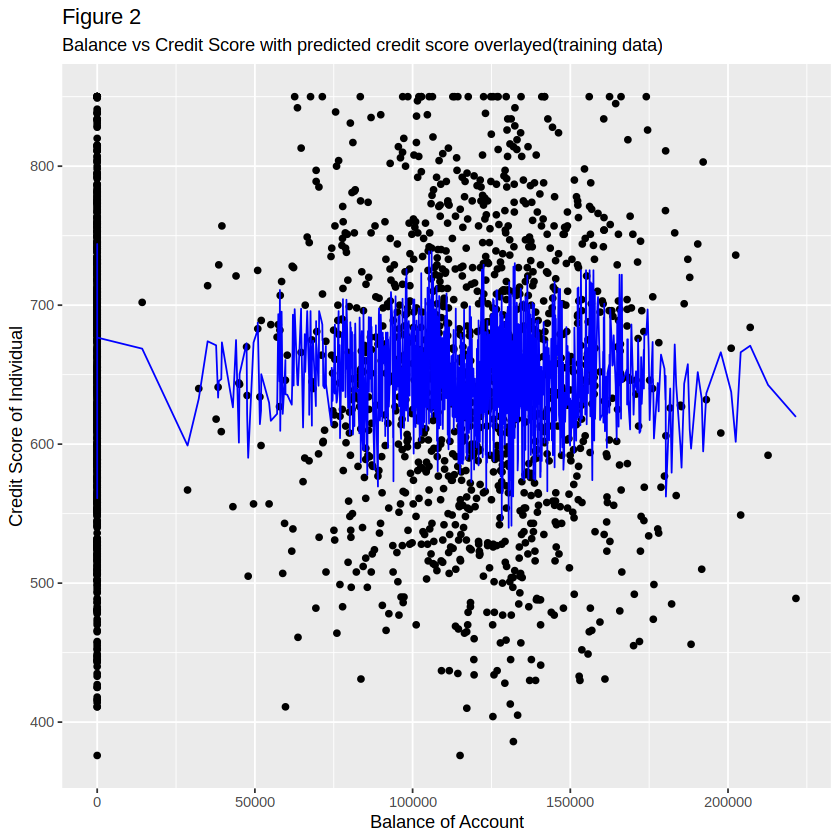

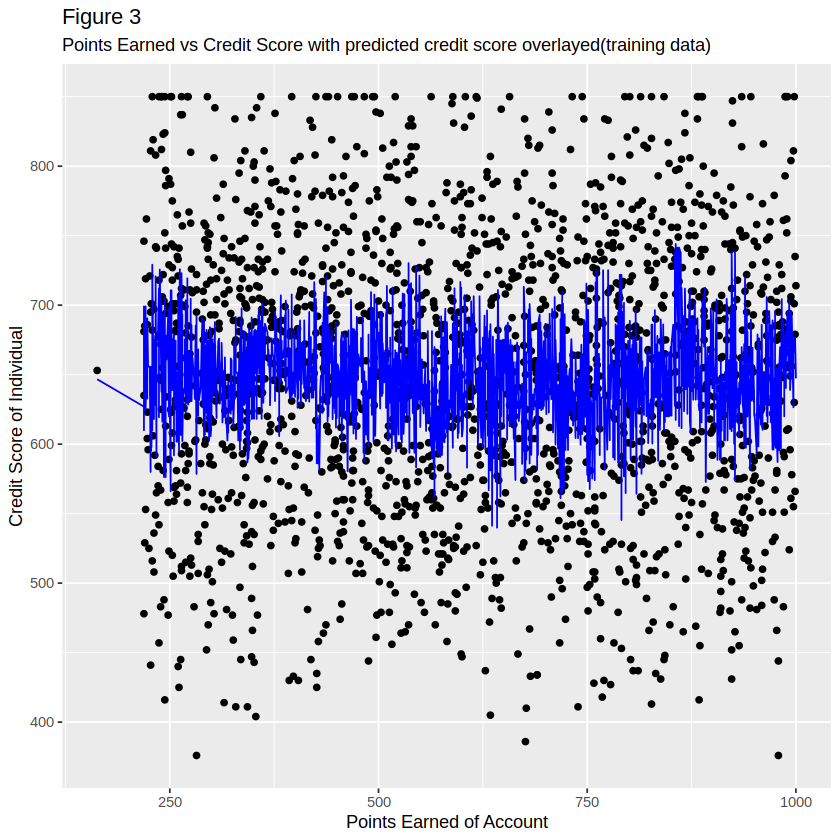

In [13]:
bank_knn_plot1 <- bank_knn_fit_10 |> predict(bank_train) |> bind_cols(bank_train)  |>ggplot(aes(x=Balance,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=Balance,y=.pred),color = "blue") + 
labs(x= "Balance of Account", y= "Credit Score of Individual",title = "Figure 2",subtitle = "Balance vs Credit Score with predicted credit score overlayed(training data)") 
bank_knn_plot1
bank_knn_plot2 <- bank_knn_fit_10 |> predict(bank_train) |> bind_cols(bank_train)  |>ggplot(aes(x=PointEarned,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=PointEarned,y=.pred),color = "blue") +
labs(x= "Points Earned of Account", y= "Credit Score of Individual",title = "Figure 3",subtitle = "Points Earned vs Credit Score with predicted credit score overlayed(training data)") 
bank_knn_plot2

Next, we can apply this model to the testing data, shown below.

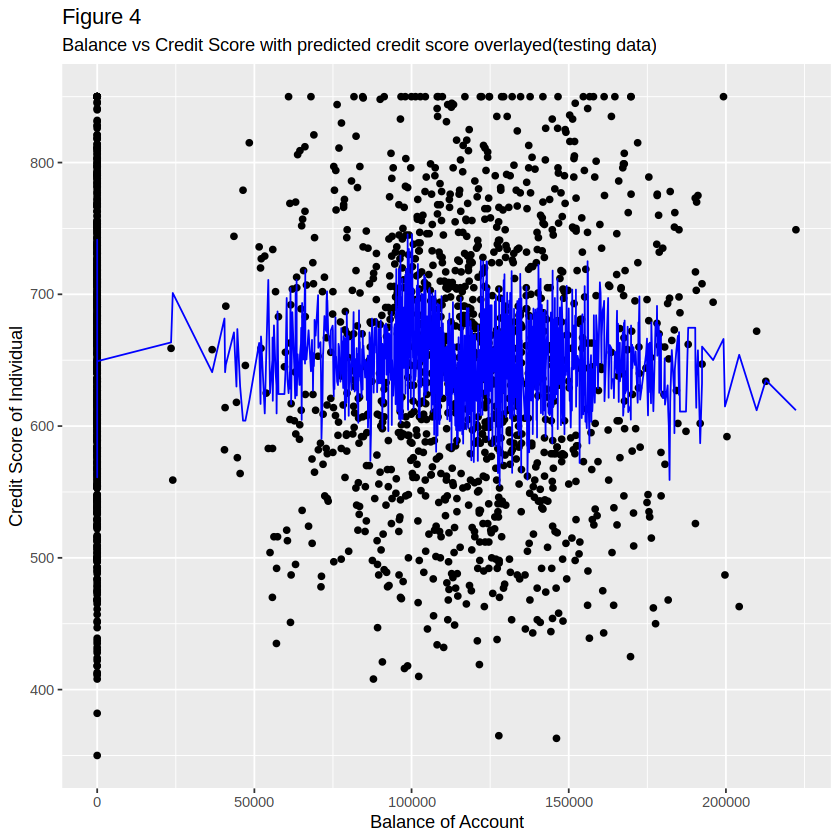

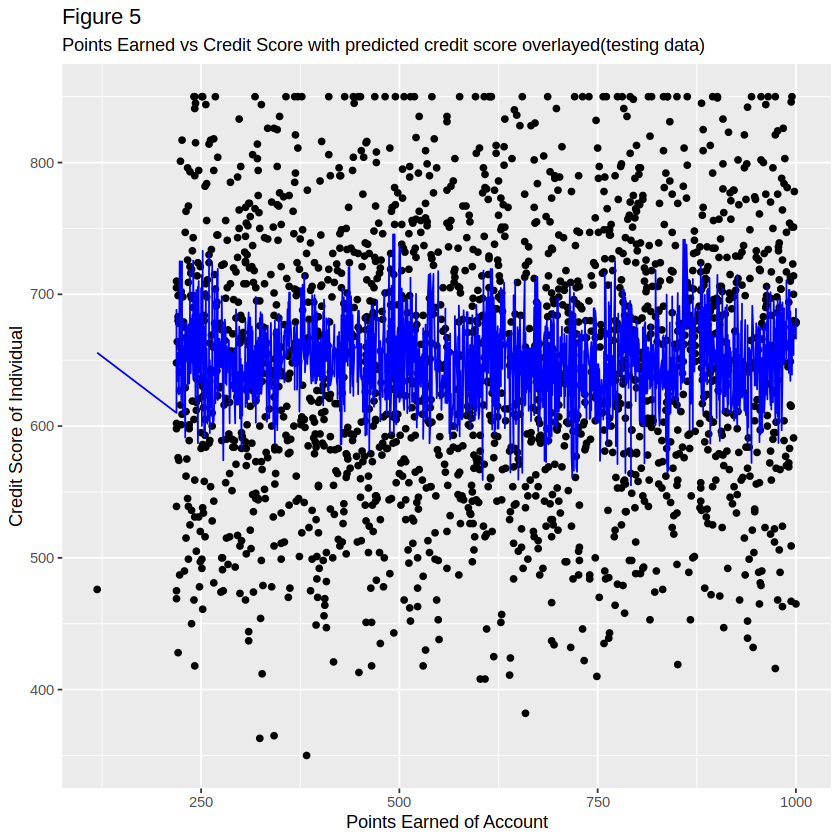

In [14]:
bank_knn_plot_test1 <- bank_knn_fit_10 |> predict(bank_test) |> bind_cols(bank_test)  |>ggplot(aes(x=Balance,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=Balance,y=.pred),color = "blue") + 
labs(x= "Balance of Account", y= "Credit Score of Individual",title = "Figure 4",subtitle = "Balance vs Credit Score with predicted credit score overlayed(testing data)") 
bank_knn_plot_test1
bank_knn_plot_test2 <- bank_knn_fit_10 |> predict(bank_test) |> bind_cols(bank_test)  |>ggplot(aes(x=PointEarned,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=PointEarned,y=.pred),color = "blue") +
labs(x= "Points Earned of Account", y= "Credit Score of Individual",title = "Figure 5",subtitle = "Points Earned vs Credit Score with predicted credit score overlayed(testing data)") 
bank_knn_plot_test2

# Discussion

 ## Q. summarize what you found, discuss whether this is what you expected to find?
The initial idea behind our investigation was looking at actionable factors that individuals could use to see what is a bigger determinant of their credit score and utilise that to maximise their own credit score. We were hoping to see whether balance plays a bigger role, points earned (to indicate higher spending) or a combination of both having a lot of savings and points earned (to indicate that they not only spend a lot but they are also financially wise and have money saved). Surprisingly, there seems to be no correlation with balance and credit score nor is there any correlation with points earned and credit score. The data shows no noticeable pattern and appears completely random; people with very high balances and points earned can have low credit scores and vice versa. It can be seen in our plots (figures 2 to 5) that there is a lot of variance in our data points and they are highly spread out but in no distinct manner that resembles some sort of linear growth or decline. There is not even a pattern indicating that it can predictably increase in a certain range or reduce in a certain range that could be leveraged by customers to stay within a certain range themselves and maximise their own credit scores when they apply for loans. When we were testing our initial data to determine predictors we found that none of the variables seemed to show any correlation with credit score even in various combinations of two or 3 variables being considered at once. This would imply there is some lurking unidentified variable that is more important in determining credit score which hasn’t been surveyed. This could likely be the likelihood of individuals to pay back on time and the size of debt acquired by individuals. We ran these tests not just with multiple variables and various combinations of each but also split each graph we ran by geography and gender to try and identify any biases but all the data appeared completely random. Balance and Points earned still seemed to have the highest correlation both amongst each other and also with credit score but this also displayed a very weak linear relation and by observing graphs we could spot no non-linear relations.

Some surprising findings when we ran our preliminary data analysis were the fact most people who complained about the service were likely to leave. Only 4 people who exited had not complained and that was because they were inactive members, and only 10 people who complained (out of 2044) did not exit. However a majority of individuals who had complained showed satisfaction ratings of 3 or above out of 5. This would be surprising because the proportion of people who rated the service 4 or 5 and still left was not very different from those who rated the service 1 or 2. It would be interesting to further explore what it is that causes these individuals to leave as it wasn’t them not having used the service in a long time or having a low balance or not using the card too often. 


## Q.Discuss what impact could such findings have?

Credit score plays a major role in our daily lives. It can influence an individual's approval for bank loans like mortgages or even if a landlord will approve you for a rent. The impact of our findings can help people understand where people stand in their credit score, i.e. if they are in good standing or bad standing. Most people assume that if they are paying off their credit cards in time their credit score will be high, but that is not always the case as there are several important factors that go into calculating one’s credit score. Credit score is an invisible factor that not many people look at daily. Once people can understand their standing, they can change their spending habits to increase their score to increase their chances of being approved by the bank. Looking at a study they found that receiving notices about their credit score significantly increased their average FICO score (Homonoff et al., 2021), FICO score is the measure used by banks to quantitatively put a number to an individual’s credit worthiness. We can see from this study that when people are able to see their credit score on paper, they are able to adjust their spending habits and understand the changes they need to make to improve their credit. A good credit score does not only increase your approval rate at banks, but it also reduces your interest payments. People with high credit scores will get better rates at the bank as Homonoff mentions “differential treatment as a function of credit scores is not always linear: banks frequently change lending terms at discrete cutoffs. For example, Federal Housing Authority loans (e.g., those issued through Fannie Mae) require a minimum credit score of 620” (Homonoff et al., 2021). It is important for one to understand how their credit score affects your life financially as it can have a big impact on your quality of life.


## Q.Discuss what future questions could this lead to? 

These findings are definitely interesting, but our resources are limited and we could not execute this project to its full potential. It would be interesting to have a pool of data that showed the full breadth of a person’s financial history to make a more concrete conclusion. This leads to future questions that we can ask such as why banks rely so heavily on FICO scores. We can also look at how one’s spending habits will change in response to knowing what their credit score is. Another interesting approach would be to compare individuals, that have a similar salary, that look and know their credit score to individuals that do not look at their scores at all and see how big of an impact does FICO score have a person’s finances when they are conscious of the affects their financial habits can either increase or decrease their score and see if they are in better standing financially or would they remain the same.   

# Citations

Homonoff, T., O'Brien, R., & Sussman, A. B.. (2021). Does Knowing Your FICO Score Change Financial Behavior? Evidence from a Field Experiment with Student Loan Borrowers. *The Review of Economics and Statistics 103* (2): 236–250. doi:https://doi.org/10.1162/rest_a_00888

Kumar, A., Shanthi, D., & Bhattacharya, P. (2021). Credit Score Prediction System using Deep Learning and K-Means Algorithms. *Journal of Physics: Conference Series, 1998*(1), 012027. https://doi.org/10.1088/1742-6596/1998/1/012027


Kmeans to predict credit score:
https://iopscience.iop.org/article/10.1088/1742-6596/1998/1/012027/meta
